Now let's do the same, but with a different method. First read the same data and import everything we need:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dataset91 = pd.read_csv('https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/dimuon_short91_f1_000.csv.gz',index_col=False)
dataset92 = pd.read_csv('https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/dimuon_short92_e2_000.csv.gz',index_col=False)
dataset93 = pd.read_csv('https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/dimuon_short93_d2_000.csv.gz',index_col=False)
dataset94 = pd.read_csv('https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/dimuon_short94_c2_000.csv.gz',index_col=False)


This method of finding the particle relies on the fact that in the large electron-positron collider we used to exclusively create Z-particles. So now we look at the results for the amount of event (Z-bosons created) for different center-of-mass energies that the collider has been running on and see where it has had the most success creating Z-bosons, relative to the amount of attempts. 

To do that, we need to define the integrated luminosity for each event. Luminosity is defined as

$$
L = \dfrac{1}{\sigma} \dfrac{dN}{dt}
$$

meaning it is the rate of events divided by cross-section. Cross-section describes the probability of the colliding particles actually causing a reaction. Therefore integraded luminosity is just the total number of events divided by the cross-section. Because the cross-section is different for different values of center-of-mass energy (ECM) and it becomes larges as ECM gets closer to the actual mass of the particle, it makes for a good metric to find the particle. To get the cross-section, we can divide the number of datapoints we have for a value of ECM by the integrated luminosity. 

Since each center-of-mass energy (ECM) value has a different luminosity we need to find all ECM values and that can be done by using .ECM.unique() function on the dataset. From that we can see some values that are quite close to each other. This is beccause of noise in the measurement and can be ignored. Doing that we find that there are 7 different values for ECM. Using the table given we can assing a luminosity to each datapoint in the dataset by doing the following. This is done by first sorting the dataset by ECM, then finding the point in which ECM value changes using .index[0]. Lastly the values can be assigned using .loc where we can specify rows and columns which we want to assign the value to. 

In [2]:
#values sorted by ECM (for convenience of programming)
dataset91 = dataset91.sort_values(['ECM']) 
dataset91 = dataset91.reset_index(drop = True) #correct index after sort

#section 1: 
slice_index1 = dataset91[dataset91.ECM == 89.506].index[0] 
lum1 = 629 #luminosity for this section
dataset91.loc[0:slice_index1-1, "LUM"] = lum1

#section 2: 
slice_index2 = dataset91[dataset91.ECM == 90.256].index[0] 
lum2 = 647 #luminosity for this section
dataset91.loc[slice_index1:slice_index2-1, "LUM"] = lum2

#section 3: 
slice_index3 = dataset91[dataset91.ECM == 91.25].index[0] 
lum3 = 633 #luminosity for this section
dataset91.loc[slice_index2:slice_index3-1, "LUM"] = lum3

#section 4: 
slice_index4 = dataset91[dataset91.ECM == 92.004].index[0] 
lum4 = 2274 #luminosity for this section
dataset91.loc[slice_index3:slice_index4-1, "LUM"] = lum4

#section 5: 
slice_index5 = dataset91[dataset91.ECM == 93.015].index[0] 
lum5 = 680 #luminosity for this section
dataset91.loc[slice_index4:slice_index5-1, "LUM"] = lum5

#section 6: 
slice_index6 = dataset91[dataset91.ECM == 93.765].index[0] 
lum6 = 634 #luminosity for this section
dataset91.loc[slice_index5:slice_index6-1, "LUM"] = lum6

#section 7: 
lum7 = 492 #luminosity for this section
dataset91.loc[slice_index6:, "LUM"] = lum7


Important note: Making copies of each section, changing them and then creating a new dataset from the copies is incredibly inefficient, but much easier to understand in my opinion. Since we are making something that could be used for education, I'm going to write this method in this comment for now. It's far easier to understand than .loc which is just a niche feature of pandas. The result is exactly the same.

section 1:

slice_index1 = dataset91[dataset91.ECM == 89.506].index[0]

section1 = dataset91[0:slice_index1]

lum_lst88 = 711.1 #luminosity for this section

section1["Normalised"] = np.divide(section1.M, lum_lst88)

at the end combine sections:

dataset91 = [section1, section2, section3,...]

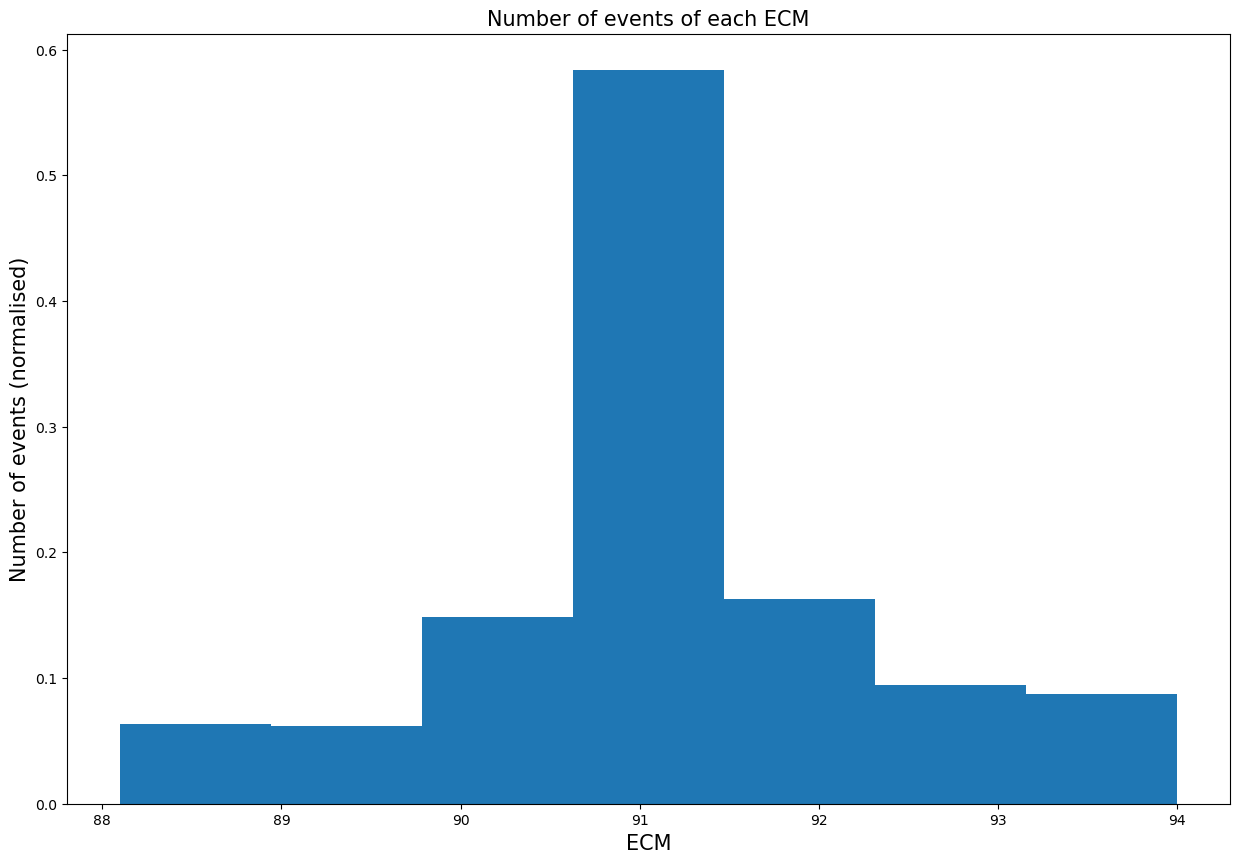

In [8]:
lowerlimit = 88.1
upperlimit = 94
bins=7


#weighted by luminosity
fig = plt.figure(figsize=(15, 10))
plt.hist(dataset91.ECM, bins=bins, range=(lowerlimit,upperlimit), weights = 1/dataset91.LUM)

plt.xlabel('ECM', fontsize=15)
plt.ylabel('Number of events (normalised)', fontsize=15)
plt.title('Number of events of each ECM', fontsize=15) 

plt.show()

Now that we have the histogram we can start analysing it. There is a peak (often called a resonance) at around 103 GeV. This peak signifies a particle. We can actually get more from this histogram. This is done by plotting what is called a Breit-Wigner function on the histogram. Breit-Wigner distribution is of the following form:

$$
f(E) = \dfrac{k}{(E^2 - M^2)^2 + M^2 \Gamma^2} 
$$

where $k = \dfrac{2\sqrt{2}M \Gamma \gamma}{\pi\sqrt{M^2 + \gamma}}$ with $\gamma = \sqrt{M^2(M^2 + \Gamma^2)}$ which are in natural units $\hbar = c = 1$. 

(Resonance here seems wide, wasn't there a variation that should be used when its too wide, whatever too wide even is)

Let's start with the simple parts of the fitting. First we only cover the area around where we know the particle is by setting limits to the mass values we use and remove the rest from the dataset. Then we set the initial guesses. In this fit there are 5 variables. We can guess that the max values is the peak we saw in the histogram. The rest we can guess and if the plot isn't good try again. (Are they always positive? It seems so by testing)

In [4]:
histogram = plt.hist(dataset91.ECM, bins=bins, range=(lowerlimit,upperlimit), weights = 1/dataset91.LUM, density = True)
plt.close() #stop from showing the plot

#Initial guesses:
initials = [1, 91, 1, 3, 1]


Next step is to create the fit. First we define a function that matches the form of the Breit-Wigner function given earlier. Then we fit this function into the histogram by using curve_fit() from scipy.optimize. Let's also save the best values and covariance that the fitting gives us. 

In [5]:
from scipy.optimize import curve_fit


def breitwigner(E, gamma, M, a, b, A):
    return a*E+b+A*( (2*np.sqrt(2)*M*gamma*np.sqrt(M**2*(M**2+gamma**2)))/(np.pi*np.sqrt(M**2+np.sqrt(M**2*(M**2+gamma**2)))) )/((E**2-M**2)**2+M**2*gamma**2)

#use the histogram to make a function:
y = histogram[0]
x = 0.5*(histogram[1][0:-1] + histogram[1][1:])
best, covariance = curve_fit(breitwigner, x, y, p0=initials, sigma=np.sqrt(y))

Lastly we plot both this fitted function and the histogram into the same picture. We can also print the best values and their limits of error, which can be easily calculated from the covariance. To smooth out the fit we set the step size for it to be 0,2. 

The values and the uncertainties from the optimization:

The value of the decay width = 0.7886296777518552 +- 0.09183900560130055
The value of the maximum of the distribution = 91.07702222579204 +- 0.07029965170758923
a = 0.006024170233048049 +- 0.0029970235466081634
b = -0.4919177302541705 +- 0.2717966535845466
A = 0.6466390571041808 +- 0.07850186062726901


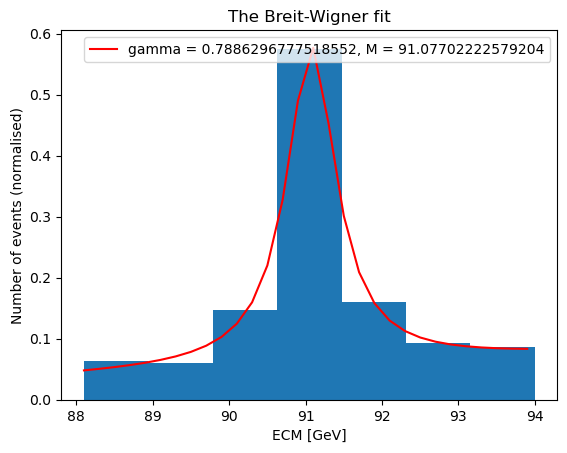

In [6]:
error = np.sqrt(np.diag(covariance))
    
#Parameters and their errors from optimization:
print("The values and the uncertainties from the optimization:")
print("")
print("The value of the decay width = {} +- {}".format(best[0], error[0]))
print("The value of the maximum of the distribution = {} +- {}".format(best[1], error[1]))
print("a = {} +- {}".format(best[2], error[2]))
print("b = {} +- {}".format(best[3], error[3]))
print("A = {} +- {}".format(best[4], error[4]))

#For the smoother fit:
more_points = np.arange(lowerlimit,upperlimit, step=0.2)


#plot both graphs:
plt.hist(dataset91.ECM, bins=bins, range=(lowerlimit,upperlimit), weights = 1/dataset91.LUM, density = True)
plt.plot(more_points, breitwigner(more_points, *best), 'r-', label='gamma = {}, M = {}'.format(best[0], best[1]))
plt.xlabel('ECM [GeV]')
plt.ylabel('Number of events (normalised)')
plt.title('The Breit-Wigner fit')
plt.legend()
plt.show()

Well what do we get out of this? Well now we know the value of gamma, which is the resonance width. It is also connected to mean lifetime of the particle which the resonance correlates to. (Do the other variables mean anything?). The mean lifetime can be calculated from the formula:

$$
\Gamma = \dfrac{\hbar}{\tau}
$$

where $\hbar$ is the reduced Planck constant and $\tau$ the lifetime of the particle. 

An interesting comparison can be made using the cross-section values already calculated in the table. If we plot them and make a similar fit we get this figure:

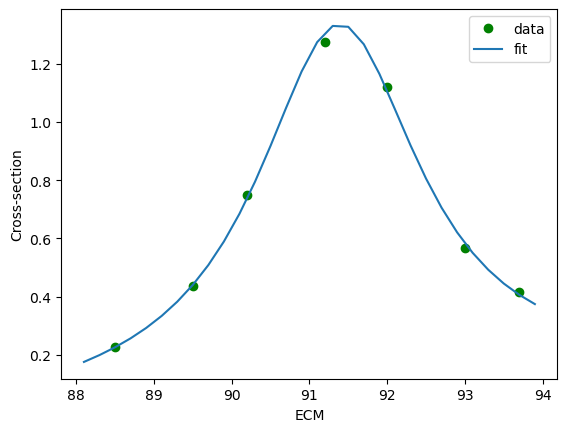

In [7]:
ECM = np.array([88.5, 89.5, 90.2, 91.2, 92, 93, 93.7], dtype=float)
cross_section = np.array([0.227, 0.436, 0.750, 1.275, 1.120, 0.568, 0.415], dtype=float)

best, covariance = curve_fit(breitwigner, ECM, cross_section, p0=initials, sigma=np.sqrt(y))



plt.plot(ECM, cross_section, 'go', label='data')
plt.plot(more_points, breitwigner(more_points, *best), '-', label='fit')
plt.xlabel("ECM")
plt.ylabel("Cross-section")
plt.legend()
plt.show()

There are actually quite a few differences. Mainly the datapoint at 92 GeV is signifantly higher. This is because the number of events according to the table is significantly higher than in the dataset. All of them seem to have lost datapoints, but that one has been affected the most. Another one is 88,5 GeV. That one has the same amount of datapoints in the dataset as 89,5 GeV but only half in the table. 